In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

TypeError: unsupported operand type(s) for |: 'types.GenericAlias' and 'types.GenericAlias'

In [15]:
class stock_info:
    def __init__(self, filepath, target_col):
        # Load data from HDF file
        self.raw = pd.read_hdf(filepath, key="/d")
        
        # Extract the target column i.e "IC"
        self.target_raw = self.raw[target_col]
        
        # Get the list of dates
        self.dates = self.target_raw.index.tolist()
        
        # initiate a new dataframe recording daily return 
        self.readouts = pd.DataFrame(self.dates, columns=["dates"])
        self.readouts.set_index("dates", inplace=True)
        
        # Calculate T_last_close and T_vap (VWAP)
        self.readouts["T_last_close"] = [
            self.target_raw.loc[date]["Close"].iloc[-1] for date in self.dates
        ]
        self.readouts["T_vap"] = [
            (self.target_raw.loc[date]["Close"] * self.target_raw.loc[date]["Volume"]).sum() /
            self.target_raw.loc[date]["Volume"].sum()
            for date in self.dates
        ]
        
        # Calculate default strategy
        # if the last close price is higher than VWAP (T_vap), sell (-1), otherwise buy (+1)
        ratio = np.array(self.readouts["T_last_close"]) / np.array(self.readouts["T_vap"])
        self.readouts["default_st"] = np.where(ratio > 1., -1, 1)

    def evaluate_return_T_p1(self, t_exec, strategy_array_name="default_st"):
        # read strategy for T+1; +1 for long and -1 for short
        strategy_ = np.array(self.readouts[strategy_array_name].tolist()[:-2])
        
        # read close price at specified time in T+1 and T+2 respectively
        short_price_T_p1 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[1:-1]])
        long_price_T_p2 = np.array([self.target_raw.loc[day]["Close"].iloc[t_exec] for day in self.dates[2:]])
        
        # calculate return rate at T+1
        return_rate_T_p1 = pd.Series(((long_price_T_p2/short_price_T_p1)-1.)*strategy_, index=self.dates[:-2])
        
        # append to self.readouts
        self.readouts["return_"+strategy_array_name+"_"+str(t_exec)] = return_rate_T_p1

    def get_sharpe_ratio(self, strategy_return):
        # obtain return rate under specified strategy
        return_arr = self.readouts[strategy_return].tolist()[:-2]
        
        # calculate traditional sharpe ratio
        sharpe_ratio = np.sqrt(250.)*np.mean(return_arr)/np.std(return_arr)
        return sharpe_ratio

    def generate_time_dependency(self, strategy_array_name):
        fig, ax1 = plt.subplots(1, 1)
        
        # array of trading time
        fibonnacci = [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 239]
        return_arr = []
        
        for t_exec in fibonnacci:
            # calculate return rate of combinations of strategy with different trading times
            self.evaluate_return_T_p1(t_exec, strategy_array_name=strategy_array_name)
            # record sharpe ratio
            return_arr.append(self.get_sharpe_ratio(strategy_return="return_"+strategy_array_name+"_"+str(t_exec)))
            
        # plot sensitivity    
        ax1.plot(fibonnacci, return_arr, label="sharpe ratio", c="blue")
        ax1.scatter(fibonnacci, return_arr, c="blue")
        title = "time sensitivity of " + strategy_array_name
        ax1.set_title(title)
        ax1.set_xlabel("trading time (min)")
        ax1.set_ylabel("sharpe ratio")
        plt.legend()
        plt.show()


In [16]:
mydata = stock_info("MinutesIdx.h5", "IC")
mydata.evaluate_return_T_p1(59)
print(mydata.readouts)

TypeError: Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got numpy.ndarray)

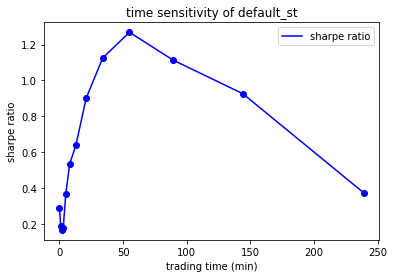

In [9]:
mydata.generate_time_dependency("default_st")